# Setup

In [1]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)
# print("cwd is now:", Path.cwd())

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from data_loader import scores_df
from fit import fit_statistical_model
import statsmodels.api as sm
from scipy.stats import linregress
from scipy.stats import gmean
from scipy.stats import t
from typing import Union, Optional

null performances after coercion: 295
after saturation filter 2343
after filter num benchmarks 1515
after merge with model versions 1511
after date filter (>= 2022-11-01) 1334
after merge with benchmark dates 1334
Original number of rows: 1334
Number of rows after aggregation: 995


In [3]:
# Merge distilled metadata locally into a copy of scores_df
try:
    df_distilled = pd.read_csv("data/distilled_models.csv")[["model", "distilled", "confidence"]]
    df_distilled.loc[df_distilled['model'] == 'claude-3-5-sonnet-20240620', 'distilled'] = False
    df_distilled.loc[df_distilled['model'] == 'claude-3-5-sonnet-20241022', 'distilled'] = False
except FileNotFoundError:
    df_distilled = pd.DataFrame(columns=["model", "distilled", "confidence"])  # empty frame if file missing

scores_df_aug = scores_df.merge(df_distilled, on="model", how="left")

In [6]:
anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
# df1, df_cm1, df_db1 = fit_statistical_model(scores_df, anchor_benchmark, anchor_difficulty, anchor_slope)
anchor_mode = "benchmark" # "model", "benchmark"
anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
anchor_model1 = "claude-2.0"
anchor_model1_capability = 1.177630
anchor_model2 = "claude-3-opus-20240229"
anchor_model2_capability = 1.311554

df1, df_cm1, df_db1 = fit_statistical_model(
    scores_df_aug,
    anchor_mode=anchor_mode,
    anchor_benchmark=anchor_benchmark,
    anchor_difficulty=anchor_difficulty,
    anchor_slope=anchor_slope,
    anchor_model1=anchor_model1,
    anchor_model1_capability=anchor_model1_capability,
    anchor_model2=anchor_model2,
    anchor_model2_capability=anchor_model2_capability
)

df_cm1['date_obj'] = pd.to_datetime(df_cm1['date'])

# Convert date strings to datetime objects
df_cm1['date_obj'] = pd.to_datetime(df_cm1['date'])

`ftol` termination condition is satisfied.
Function evaluations 34, initial cost 3.6017e+01, final cost 2.7561e+00, first-order optimality 6.63e-04.


In [7]:
# Optionally filter out distilled models from df_cm1
filter_out_distilled = True  # set False to include distilled models

# Build a per-model distilled lookup from scores_df_aug
_distilled_lookup = (
    scores_df_aug[["model", "distilled", "confidence"]]
    .drop_duplicates()
    .copy()
)

# Coerce distilled to boolean-like if present
if "distilled" in _distilled_lookup.columns:
    _distilled_lookup["distilled"] = (
        _distilled_lookup["distilled"]
        .astype(str)
        .str.strip()
        .str.upper()
        .isin(["TRUE", "1", "YES"])
    )
else:
    _distilled_lookup["distilled"] = False

# Merge flags into df_cm1 and apply optional filter
if "model" in df_cm1.columns:
    df_cm1 = df_cm1.merge(_distilled_lookup, on="model", how="left")
    if filter_out_distilled:
        df_cm1 = df_cm1[~df_cm1["distilled"].fillna(False)].reset_index(drop=True)
else:
    print("Warning: 'model' column not found in df_cm1; skipping distilled filter")


# Family approach

In [8]:
df_cap = df_cm1.copy(deep=True)

# load in data from the pcd
# pcd_dataset = pd.read_csv("https://epochai.org/data/epochdb/notable_systems.csv")[["Model", "Training compute (FLOP)", "Parameters", "Training dataset size (datapoints)"]]
pcd_dataset = pd.read_csv("data/all_ai_models.csv")[["Model", "Training compute (FLOP)", "Parameters", "Training dataset size (datapoints)"]]
columns = {"Training compute (FLOP)": "compute", "Parameters": "parameters", "Training dataset size (datapoints)": "data"}
pcd_dataset = pcd_dataset.rename(columns=columns)

df_cap = df_cap.merge(pcd_dataset, on="Model")
# df_cap.columns

df = df_cap.copy()

In [9]:
df[df["model"].str.contains("claude")]

,model_id,estimated_capability,model,is_anchor,Model,date,date_obj,distilled,confidence,compute,parameters,data
11,m69,2.241503,claude-opus-4-20250514_16K,False,Claude Opus 4,2025-05-22,2025-05-22,False,medium,NaN,NaN,NaN
12,m80,2.238017,claude-opus-4-1-20250805_16K,False,Claude Opus 4.1,2025-08-05,2025-08-05,False,medium,NaN,NaN,NaN
14,m79,2.188438,claude-opus-4-1-20250805,False,Claude Opus 4.1,2025-08-05,2025-08-05,False,medium,NaN,NaN,NaN
15,m66,2.178477,claude-opus-4-20250514,False,Claude Opus 4,2025-05-22,2025-05-22,False,medium,NaN,NaN,NaN
26,m9,1.946205,claude-3-5-sonnet-20241022,False,Claude 3.5 Sonnet,2024-10-22,2024-10-22,False,low,2.700000e+25,NaN,NaN
34,m13,1.795381,claude-3-5-sonnet-20240620,False,Claude 3.5 Sonnet,2024-06-20,2024-06-20,False,low,2.700000e+25,NaN,NaN
46,m4,1.634670,claude-3-opus-20240229,False,Claude 3 Opus,2024-02-29,2024-02-29,False,medium,1.640001e+25,NaN,NaN
54,m3,1.396515,claude-2.0,False,Claude 2,2023-07-11,2023-07-11,False,low,3.866000e+24,NaN,NaN
57,m10,1.321590,claude-2.1,False,Claude 2.1,2023-11-21,2023-11-21,False,low,NaN,NaN,NaN


In [10]:
mistral_family = [
    'mistral-large-2407',
    'mistral-large-2411',
    'mistral-medium-2505',
    # 'Mistral-7B-v0.1',
    # 'Mixtral-8x7B-v0.1',
]

qwen_family = [
    # 'qwen-max-2025-01-25',
    'qwen2.5-72b-instruct',
    # 'qwen3-235b-a22b',
    # 'Qwen-14B',
    # 'Qwen-7B',
    'Qwen2.5-72B',
    'Qwen2.5-Coder-1.5B',
    'Qwen2.5-Coder-32B',
    'Qwen2.5-Coder-7B',
    'Qwen2.5-VL-72B-Instruct',
]

phi_family = [
    'Phi-3-medium-128k-instruct',
    # 'Phi-3-mini-4k-instruct',
    'Phi-3-small-8k-instruct',
    # 'phi-1_5',
    # 'phi-2',
    # 'phi-4',
]

# grok_family = [
#     # 'grok-2-1212',
#     'grok-3-beta',
#     # 'grok-3-mini-beta_high',
#     # 'grok-3-mini-beta_low',
#     # 'grok-4-0709',
# ]

gpt4_1_family = [
    # 'text-davinci-001',
    # 'text-davinci-002',
    # 'gpt-3.5-turbo-0613',
    # 'gpt-3.5-turbo-1106',
    # 'gpt-4-0613',
    # 'gpt-4-turbo-2024-04-09',
    'gpt-4.1-2025-04-14',
    # 'gpt-4.1-mini-2025-04-14',
    # 'gpt-4.1-nano-2025-04-14',
    # 'gpt-4.5-preview-2025-02-27',
    # 'gpt2-xl',
    'o4-mini-2025-04-16_high',
    'o4-mini-2025-04-16_medium',
]

gpt4o_family = [
    'gpt-4o-2024-05-13',
    'gpt-4o-2024-08-06',
    'gpt-4o-2024-11-20',
    # 'gpt-4o-mini-2024-07-18',
    'o1-2024-12-17_high',
    'o1-2024-12-17_medium',
    # 'o1-mini-2024-09-12_high',
    # 'o1-mini-2024-09-12_medium',
    'o1-preview-2024-09-12',
    'o3-2025-04-16_high',
    'o3-2025-04-16_medium',
    # 'o3-mini-2025-01-31_high',
    # 'o3-mini-2025-01-31_medium',
]

# deepseek_family = [
#     'DeepSeek-R1',
#     'DeepSeek-R1-0528',
#     'DeepSeek-V2',
#     'DeepSeek-V3',
#     'DeepSeek-V3-0324',
# ]

llama_family = [
    'LLaMA-13B',
    'LLaMA-33B',
    'LLaMA-65B',
    'LLaMA-7B',
    # 'Llama-3.2-90B-Vision-Instruct',
    # 'Llama-3.3-70B-Instruct',
    # 'Meta-Llama-3-70B-Instruct',
    # 'Meta-Llama-3-8B-Instruct',
]

llama2_family = [
    'Llama-2-13b',
    'Llama-2-34b',
    'Llama-2-70b-hf ',
    'Llama-2-7b',
]

llama3_1_family = [
    'Llama-3.1-405B',
    'Llama-3.1-405B-Instruct',
    'Llama-3.1-70B-Instruct',
    'Llama-3.1-8B-Instruct',
]

llama4_family = [
    'Llama-4-Maverick-17B-128E-Instruct',
    'Llama-4-Maverick-17B-128E-Instruct-FP8',
    'Llama-4-Scout-17B-16E-Instruct',
]


claude_family = [
    # 'claude-2.0',
    # 'claude-3-5-haiku-20241022',
    # 'claude-3-5-sonnet-20240620',
    # 'claude-3-5-sonnet-20241022',
    # 'claude-3-7-sonnet-20250219',
    # 'claude-3-7-sonnet-20250219_16K',
    # 'claude-3-7-sonnet-20250219_32K',
    # 'claude-3-7-sonnet-20250219_64K',
    'claude-3-haiku-20240307',
    'claude-3-opus-20240229',
    'claude-3-sonnet-20240229',
    # 'claude-opus-4-1-20250805',
    # 'claude-opus-4-20250514',
    # 'claude-opus-4-20250514_16K',
    # 'claude-sonnet-4-20250514',
    # 'claude-sonnet-4-20250514_16K',
    # 'claude-sonnet-4-20250514_32K'
]

# gemini_family = [
#     'gemini-1.5-flash-001',
#     'gemini-1.5-flash-002',
#     'gemini-1.5-pro-001',
#     'gemini-1.5-pro-002',
#     'gemini-2.0-flash-001',
#     'gemini-2.0-flash-thinking-exp-01-21',
#     'gemini-2.0-pro-exp-02-05',
#     'gemini-2.5-flash-preview-04-17',
#     'gemini-2.5-flash-preview-05-20',
#     'gemini-2.5-pro-exp-03-25',
#     'gemini-2.5-pro-preview-03-25',
#     'gemini-2.5-pro-preview-05-06',
#     'gemini-2.5-pro-preview-06-05',
# ]

# gemma_family = [
#     # 'gemma-2-27b-it',
#     # 'gemma-2-9b-it',
#     # 'gemma-2b',
#     # 'gemma-3-27b-it',
#     # 'gemma-7b',
# ]

In [11]:
min_models = 3

all_families = {
    'Mistral': mistral_family,
    'Qwen': qwen_family,
    'Phi': phi_family,
    # 'Grok': grok_family,
    'GPT-4.1': gpt4_1_family,
    # 'GPT-4o': gpt4o_family,
    # 'DeepSeek': deepseek_family,
    'LLaMA': llama_family,
    'LLaMA 2': llama2_family,
    'LLaMA 3.1': llama3_1_family,
    # 'LLaMA 4': llama4_family,
    'Claude': claude_family,
    # 'Gemini': gemini_family,
    # 'Gemma': gemma_family,
}

# Check which families have sufficient data (>= 2 models with compute data)
valid_families = {}
family_stats = {}
for family_name, family_models in all_families.items():
    family_data = df[df['model'].isin(family_models) & df['compute'].notna()]
    if len(family_data) >= min_models:
        valid_families[family_name] = family_models
        family_stats[family_name] = {
            'count': len(family_data),
            'models': family_data['model'].tolist(),
            'compute_range': (family_data['compute'].min(), family_data['compute'].max()),
            'capability_range': (family_data['estimated_capability'].min(), family_data['estimated_capability'].max())
        }

print(f"Valid families with >= {min_models} models having compute data:")
for family_name, stats in family_stats.items():
    print(f"\n{family_name}: {stats['count']} models")
    print(f"  Models: {stats['models']}")
    print(f"  Compute range: {stats['compute_range'][0]:.2e} - {stats['compute_range'][1]:.2e} FLOPs")
    print(f"  Capability range: {stats['capability_range'][0]:.3f} - {stats['capability_range'][1]:.3f}")

print(f"\nTotal valid families: {len(valid_families)}")

Valid families with >= 3 models having compute data:

LLaMA: 4 models
  Models: ['LLaMA-65B', 'LLaMA-33B', 'LLaMA-13B', 'LLaMA-7B']
  Compute range: 4.00e+22 - 5.50e+23 FLOPs
  Capability range: 0.733 - 1.179

LLaMA 2: 4 models
  Models: ['Llama-2-70b-hf ', 'Llama-2-13b', 'Llama-2-34b', 'Llama-2-7b']
  Compute range: 8.40e+22 - 8.10e+23 FLOPs
  Capability range: 0.801 - 1.318

LLaMA 3.1: 4 models
  Models: ['Llama-3.1-405B', 'Llama-3.1-405B-Instruct', 'Llama-3.1-70B-Instruct', 'Llama-3.1-8B-Instruct']
  Compute range: 1.22e+24 - 3.80e+25 FLOPs
  Capability range: 1.344 - 1.909

Total valid families: 3


In [12]:
print("=" * 70)
print("TWO-STAGE APPROACH: ALGORITHMIC PROGRESS ANALYSIS")  
print("=" * 70)
print("\nSTAGE 1: Estimate k values per family (without temporal analysis)")
print("=" * 70)

# Step 1: For each family with sufficient data, estimate k only
family_k_estimates = {}

for family_name, family_models in all_families.items():
    family_data = df[df['model'].isin(family_models) & df['compute'].notna()].copy()
    
    if len(family_data) >= min_models:
        # Sort by date to see temporal progression
        family_data = family_data.sort_values('date')
        
        log_compute = np.log(family_data['compute'])
        capabilities = family_data['estimated_capability']
        
        # Check if we have sufficient variation in compute values
        if len(log_compute.unique()) > 1:
            # Fit family-specific k (compute scaling coefficient)
            slope_k, intercept, r_value, p_value, std_err = linregress(log_compute, capabilities)
            
            family_k_estimates[family_name] = {
                'family_k': slope_k,
                'k_r_squared': r_value**2,
                'k_std_err': std_err,
                'n_models': len(family_data),
                'date_range': (family_data['date'].min(), family_data['date'].max()),
                'data': family_data,
                'intercept': intercept
            }
            
            print(f"\n{family_name} Family:")
            print(f"  • Models: {len(family_data)} ({family_data['date'].min()} to {family_data['date'].max()})")
            print(f"  • Estimated k: {slope_k:.4f} ± {std_err:.4f} (R² = {r_value**2:.3f})")
            
            # Show the models in this family
            for idx, row in family_data.iterrows():
                print(f"    {row['date']} {row['model']:30s} C={row['estimated_capability']:.3f} F={row['compute']:.2e}")
            
        else:
            print(f"{family_name}: Insufficient compute variation (all models have same compute)")
    else:
        if len(family_data) > 0:
            print(f"{family_name}: Insufficient data ({len(family_data)} models with compute)")

print(f"\n\nSummary: Successfully estimated k for {len(family_k_estimates)} families")
print("=" * 70)

# Calculate average k across families
k_values = [results['family_k'] for results in family_k_estimates.values()]
k_weights = [results['n_models'] for results in family_k_estimates.values()]  # Weight by number of models

# Simple average
k_mean_simple = np.mean(k_values)
k_std_simple = np.std(k_values)

# Weighted average (by number of models in each family)
k_mean_weighted = np.average(k_values, weights=k_weights)

print(f"\nEstimated k values across families:")
for family_name, results in family_k_estimates.items():
    print(f"  {family_name:15s}: k = {results['family_k']:.4f} (n={results['n_models']})")

print(f"\nAverage k (simple): {k_mean_simple:.4f} ± {k_std_simple:.4f}")
print(f"Average k (weighted by n): {k_mean_weighted:.4f}")

# Use the weighted average going forward
k_fixed = k_mean_weighted
print(f"\n>>> USING FIXED k = {k_fixed:.4f} for Stage 2 <<<")

TWO-STAGE APPROACH: ALGORITHMIC PROGRESS ANALYSIS

STAGE 1: Estimate k values per family (without temporal analysis)
Mistral: Insufficient data (2 models with compute)
Qwen: Insufficient data (2 models with compute)

LLaMA Family:
  • Models: 4 (2023-02-24 to 2023-02-27)
  • Estimated k: 0.1728 ± 0.0059 (R² = 0.998)
    2023-02-24 LLaMA-65B                      C=1.179 F=5.50e+23
    2023-02-24 LLaMA-7B                       C=0.733 F=4.00e+22
    2023-02-27 LLaMA-33B                      C=1.081 F=2.73e+23
    2023-02-27 LLaMA-13B                      C=0.850 F=7.80e+22

LLaMA 2 Family:
  • Models: 4 (2023-07-18 to 2023-07-18)
  • Estimated k: 0.1945 ± 0.0666 (R² = 0.810)
    2023-07-18 Llama-2-70b-hf                 C=1.318 F=8.10e+23
    2023-07-18 Llama-2-13b                    C=0.982 F=1.60e+23
    2023-07-18 Llama-2-34b                    C=0.975 F=4.08e+23
    2023-07-18 Llama-2-7b                     C=0.801 F=8.40e+22

LLaMA 3.1 Family:
  • Models: 4 (2024-07-23 to 2024-07-23

In [13]:
print("\n\n" + "=" * 70)
print("STAGE 2: Fit b values over time with fixed k")
print("=" * 70)

# Now use fixed k to calculate b for ALL models with compute data
all_models_with_compute = df[df['compute'].notna()].copy()
all_models_with_compute['log_compute'] = np.log(all_models_with_compute['compute'])
all_models_with_compute['date_numeric'] = (
    pd.to_datetime(all_models_with_compute['date']).dt.year + 
    pd.to_datetime(all_models_with_compute['date']).dt.dayofyear / 365.25
)

# Calculate b for each model using fixed k: b = C - k * ln(F)
all_models_with_compute['b'] = (
    all_models_with_compute['estimated_capability'] - 
    k_fixed * all_models_with_compute['log_compute']
)

print(f"\nUsing {len(all_models_with_compute)} models with compute data")
print(f"Date range: {all_models_with_compute['date'].min()} to {all_models_with_compute['date'].max()}")

# Fit temporal trend in b across all models
b_slope, b_intercept, b_r_value, b_p_value, b_std_err = linregress(
    all_models_with_compute['date_numeric'], 
    all_models_with_compute['b']
)

print(f"\nTemporal trend in b:")
print(f"  db/dt = {b_slope:.4f} ± {b_std_err:.4f} per year")
print(f"  R² = {b_r_value**2:.3f}")
print(f"  p-value = {b_p_value:.3e}")

# Convert to algorithmic progress rate
# If C = k*ln(F) + b(t), and b(t) = b0 + (db/dt)*t
# Then to maintain same C, we need: k*ln(F2/F1) = -(db/dt)*Δt
# So F2/F1 = exp(-(db/dt)*Δt / k)
# For annual improvement: F_new/F_old = exp(-(db/dt) / k)

compute_ratio_per_year = np.exp(-b_slope / k_fixed)
efficiency_improvement_per_year = 1 / compute_ratio_per_year

# 90% CI for efficiency improvement via t-based CI on slope
n_obs = len(all_models_with_compute)
df_dof = max(1, n_obs - 2)
t90 = t.ppf(0.95, df=df_dof)
_eff_low = np.exp((b_slope - t90 * b_std_err) / k_fixed)
_eff_high = np.exp((b_slope + t90 * b_std_err) / k_fixed)
eff_improve_90_lo, eff_improve_90_hi = _eff_low, _eff_high

print(f"\nAlgorithmic Progress Interpretation:")
print(f"  • Annual efficiency improvement: {efficiency_improvement_per_year:.2f}× (90% CI: {eff_improve_90_lo:.2f}–{eff_improve_90_hi:.2f}×)")
print(f"  • Halving time (2× efficiency): {np.log(2) / np.log(efficiency_improvement_per_year):.2f} years")
if efficiency_improvement_per_year > 1:
    print(f"  • Each year, need {compute_ratio_per_year:.3f}× the compute for same capability")
    print(f"  • Equivalently: Same compute gives {efficiency_improvement_per_year:.2f}× better capability/year")



STAGE 2: Fit b values over time with fixed k

Using 61 models with compute data
Date range: 2023-02-24 to 2025-07-12

Temporal trend in b:
  db/dt = 0.1772 ± 0.0412 per year
  R² = 0.239
  p-value = 6.478e-05

Algorithmic Progress Interpretation:
  • Annual efficiency improvement: 2.90× (90% CI: 1.92–4.39×)
  • Halving time (2× efficiency): 0.65 years
  • Each year, need 0.344× the compute for same capability
  • Equivalently: Same compute gives 2.90× better capability/year


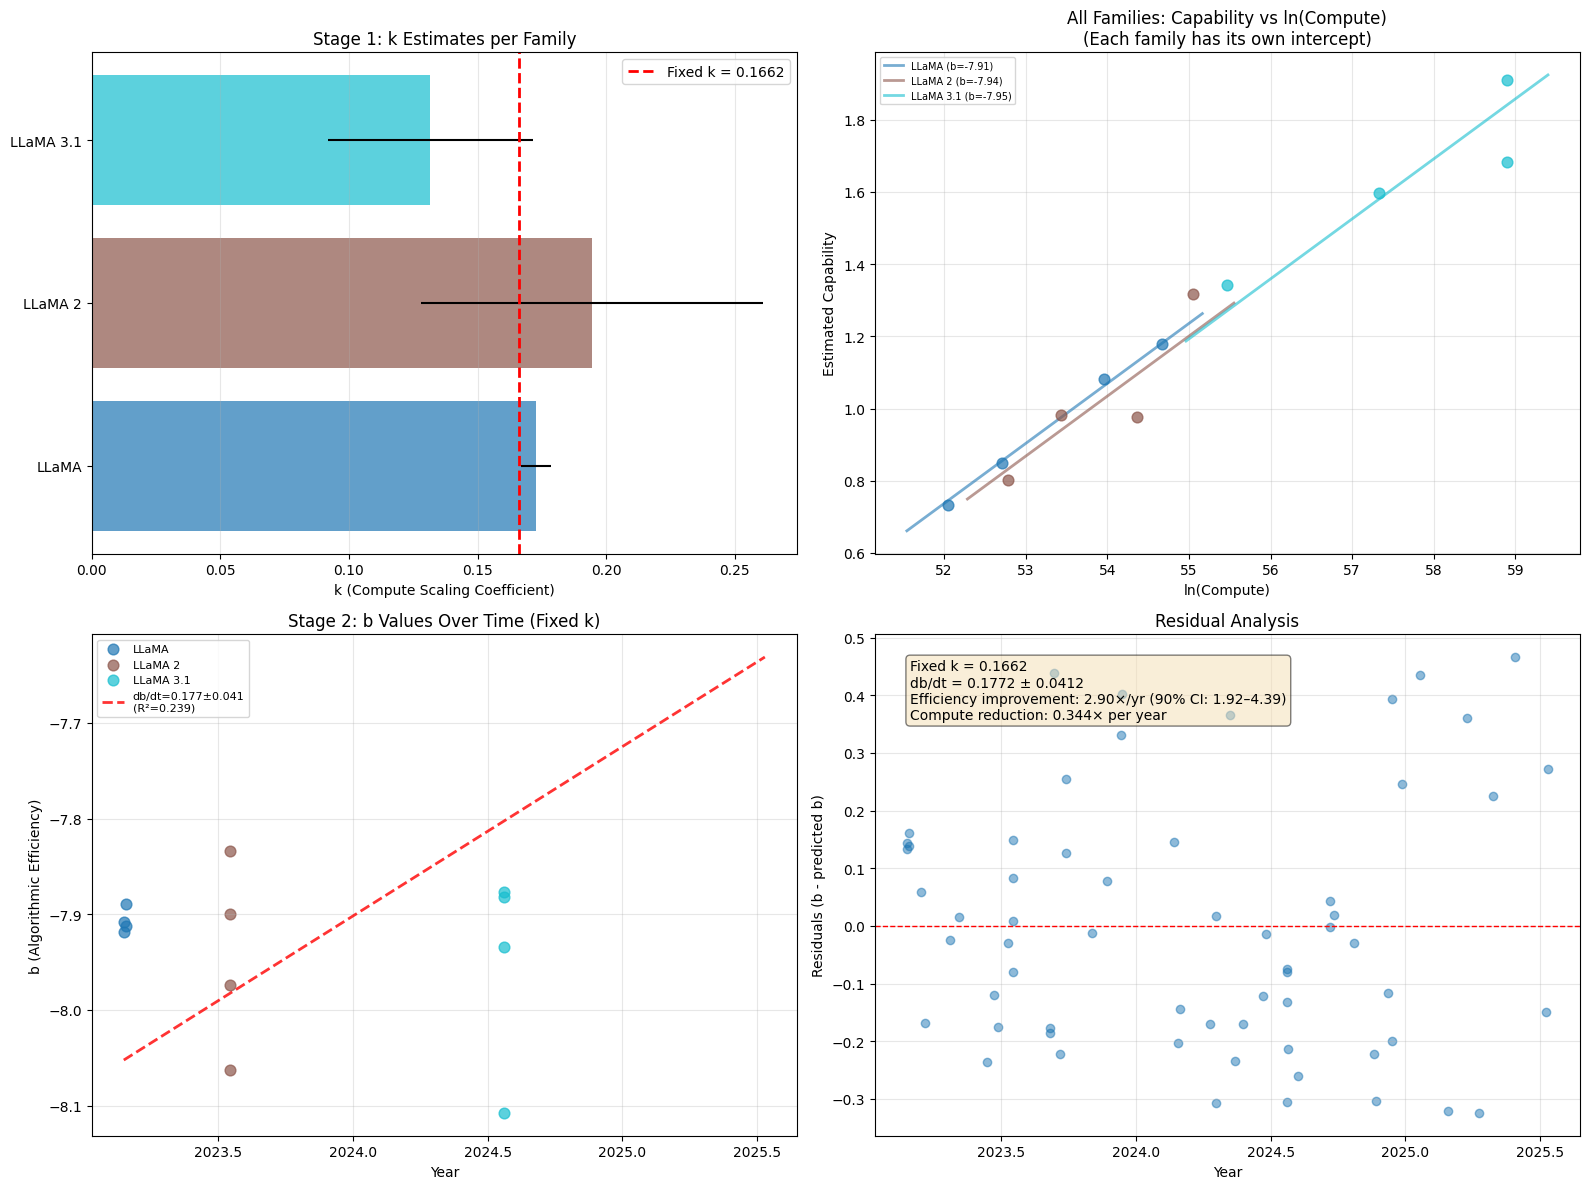


ANALYSIS COMPLETE


In [14]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: k estimates per family
ax1 = axes[0, 0]
family_names = list(family_k_estimates.keys())
k_vals = [family_k_estimates[fn]['family_k'] for fn in family_names]
k_errs = [family_k_estimates[fn]['k_std_err'] for fn in family_names]
colors = plt.cm.tab10(np.linspace(0, 1, len(family_names)))

ax1.barh(family_names, k_vals, xerr=k_errs, color=colors, alpha=0.7)
ax1.axvline(k_fixed, color='red', linestyle='--', linewidth=2, label=f'Fixed k = {k_fixed:.4f}')
ax1.set_xlabel('k (Compute Scaling Coefficient)')
ax1.set_title('Stage 1: k Estimates per Family')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# Plot 2: Capability vs log(compute) for all families
ax2 = axes[0, 1]
for i, (family_name, results) in enumerate(family_k_estimates.items()):
    family_data = results['data'].copy()
    log_compute = np.log(family_data['compute'])
    capabilities = family_data['estimated_capability']
    
    # Scatter points for this family
    ax2.scatter(log_compute, capabilities, alpha=0.7, s=60, 
               color=colors[i], zorder=3)
    
    # Calculate this family's mean b value
    family_data['log_compute'] = log_compute
    family_data['b'] = family_data['estimated_capability'] - k_fixed * family_data['log_compute']
    family_mean_b = family_data['b'].mean()
    
    # Draw a line for this family with its own intercept
    # Use the family's compute range for the line
    family_log_compute_range = np.linspace(
        log_compute.min() - 0.5,
        log_compute.max() + 0.5,
        50
    )
    family_capability_line = k_fixed * family_log_compute_range + family_mean_b
    ax2.plot(family_log_compute_range, family_capability_line, '-', 
            linewidth=2, alpha=0.6, color=colors[i], 
            label=f'{family_name} (b={family_mean_b:.2f})', zorder=2)

ax2.set_xlabel('ln(Compute)')
ax2.set_ylabel('Estimated Capability')
ax2.set_title('All Families: Capability vs ln(Compute)\n(Each family has its own intercept)')
ax2.legend(fontsize=7, loc='best')
ax2.grid(True, alpha=0.3)

# Plot 3: b values over time
ax3 = axes[1, 0]
for i, (family_name, results) in enumerate(family_k_estimates.items()):
    family_data = results['data'].copy()
    family_data['log_compute'] = np.log(family_data['compute'])
    family_data['date_numeric'] = (
        pd.to_datetime(family_data['date']).dt.year + 
        pd.to_datetime(family_data['date']).dt.dayofyear / 365.25
    )
    family_data['b'] = family_data['estimated_capability'] - k_fixed * family_data['log_compute']
    
    ax3.scatter(family_data['date_numeric'], family_data['b'], 
               alpha=0.7, s=60, label=family_name, color=colors[i])

# Add temporal trend line
time_range = np.linspace(
    all_models_with_compute['date_numeric'].min(),
    all_models_with_compute['date_numeric'].max(),
    100
)
b_trend = b_slope * time_range + b_intercept
ax3.plot(time_range, b_trend, 'r--', linewidth=2, alpha=0.8,
        label=f'db/dt={b_slope:.3f}±{b_std_err:.3f}\n(R²={b_r_value**2:.3f})')

ax3.set_xlabel('Year')
ax3.set_ylabel('b (Algorithmic Efficiency)')
ax3.set_title('Stage 2: b Values Over Time (Fixed k)')
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

# Plot 4: Residuals
ax4 = axes[1, 1]
predicted_b = b_slope * all_models_with_compute['date_numeric'] + b_intercept
residuals = all_models_with_compute['b'] - predicted_b

ax4.scatter(all_models_with_compute['date_numeric'], residuals, alpha=0.5)
ax4.axhline(0, color='red', linestyle='--', linewidth=1)
ax4.set_xlabel('Year')
ax4.set_ylabel('Residuals (b - predicted b)')
ax4.set_title('Residual Analysis')
ax4.grid(True, alpha=0.3)

# Add text with key results
textstr = f'Fixed k = {k_fixed:.4f}\ndb/dt = {b_slope:.4f} ± {b_std_err:.4f}\n'
textstr += f'Efficiency improvement: {efficiency_improvement_per_year:.2f}×/yr (90% CI: {eff_improve_90_lo:.2f}–{eff_improve_90_hi:.2f})\n'
textstr += f'Compute reduction: {compute_ratio_per_year:.3f}× per year'
ax4.text(0.05, 0.95, textstr, transform=ax4.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE")
print("=" * 70)

UNIFIED FAMILY-k APPROACH: selection_mode=capability_frontier
k_fixed_fam (family-weighted): 0.1662
Stage 2 selection: Capability record frontier
  • Subset size: 15 (of 61)
db/dt (subset): 0.1828 ± 0.0978 per year (R²=0.212, p=8.42e-02)
Efficiency improvement: 3.00× per year (90% CI: 1.06–8.51×)


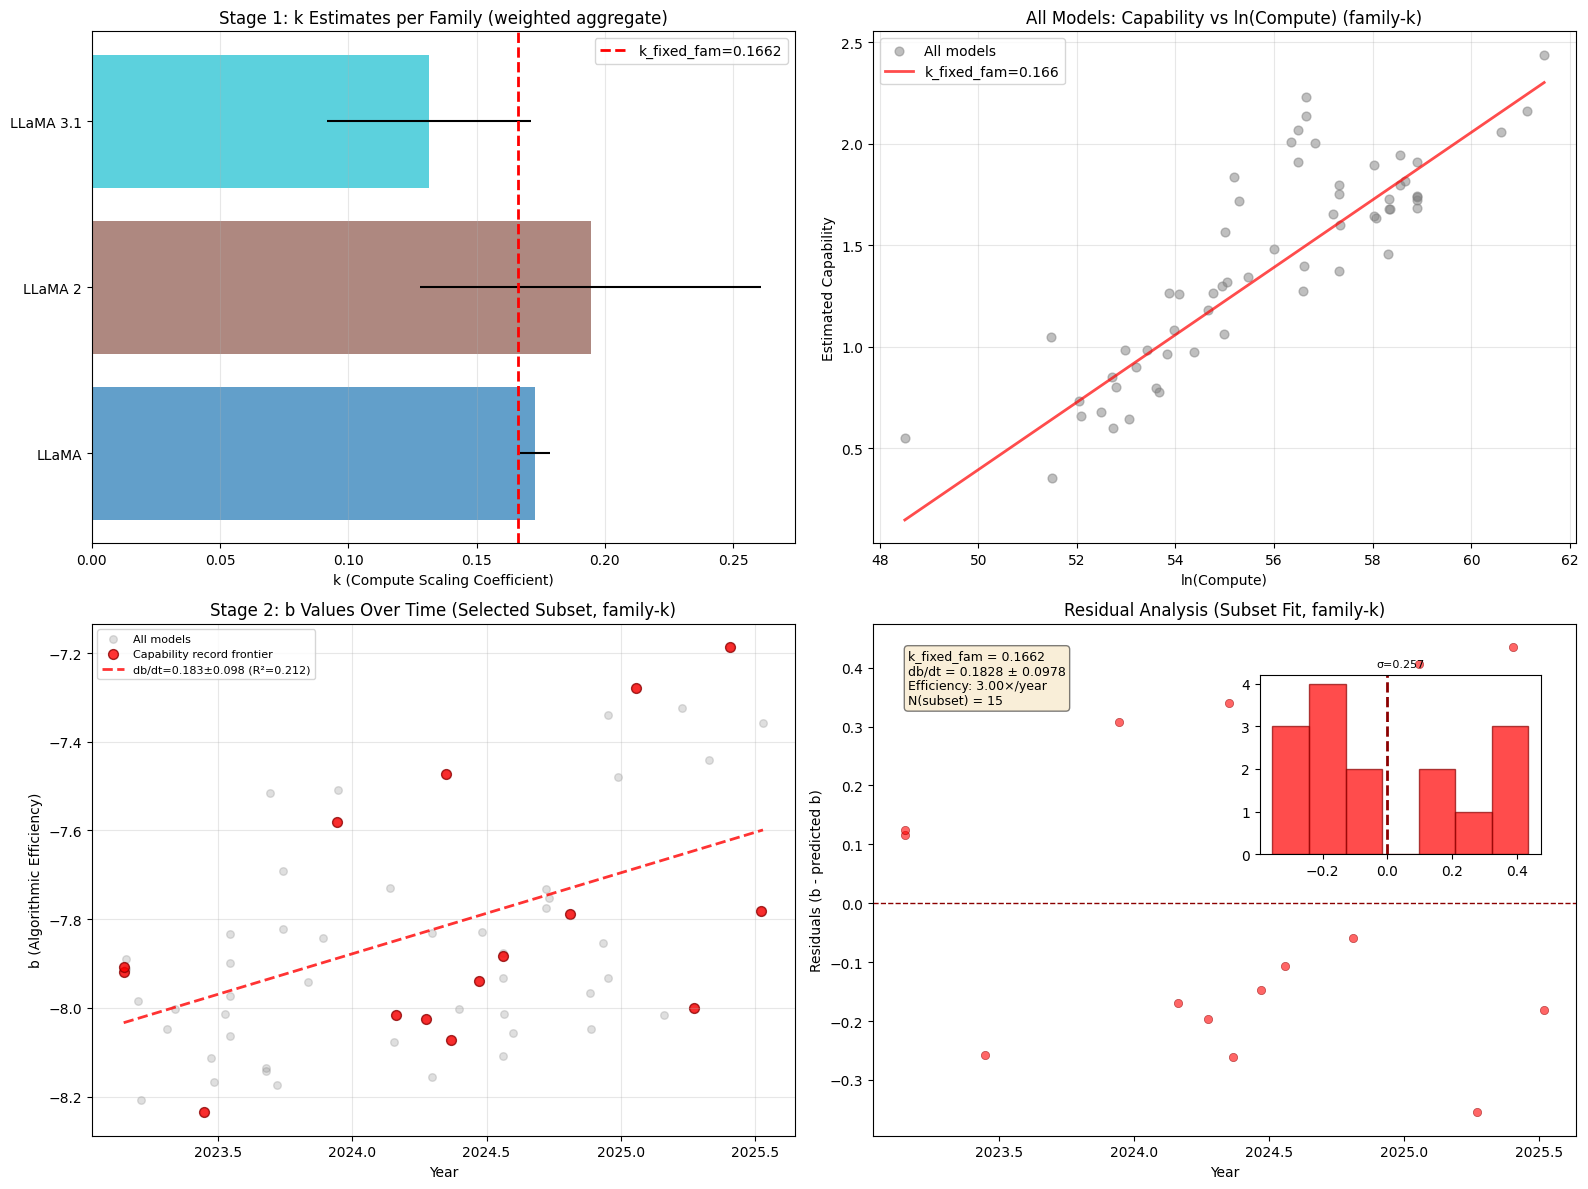

In [15]:
# ============================================================================
# Unified Family-k Approach — All Models vs Capability Frontier vs b Frontier
# - Stage 1: Estimate k per family; aggregate (weighted) to k_fixed_fam
# - Stage 2: Compute b for ALL models using k_fixed_fam, then choose subset:
#   * 'all_models': all models
#   * 'capability_frontier': frontier in estimated_capability (top-N or record)
#   * 'b_frontier': frontier in b (top-N or record)
# - Plots: Stage 1 family k overview + capability vs ln(compute),
#          Stage 2 b over time (subset), residuals, residual histogram
# ============================================================================

# Configuration
fam_selection_mode = 'capability_frontier'      # 'all_models' | 'capability_frontier' | 'b_frontier'
fam_frontier_grouping = 'year'         # 'year' | 'month' | 'date' (for per-group mode)
fam_frontier_mode = 'record'           # 'record' (running record-high) | 'per_group' (top-N per period)
fam_n_top = 1                          # N for per_group selection
min_models_for_family = min_models if 'min_models' in globals() else 3

print("=" * 70)
print(f"UNIFIED FAMILY-k APPROACH: selection_mode={fam_selection_mode}")
print("=" * 70)

# ---------------------- Stage 1: Family-wise k ----------------------
# Ensure families and compute family-specific k if missing
if 'all_families' not in globals() or not isinstance(all_families, dict) or len(all_families) == 0:
    raise ValueError("all_families dict is not defined earlier in the notebook.")

family_k_estimates_local = {}
for family_name, family_models in all_families.items():
    fam_df = df[df['model'].isin(family_models) & df['compute'].notna()].copy()
    if len(fam_df) >= min_models_for_family:
        log_compute = np.log(fam_df['compute'])
        capabilities = fam_df['estimated_capability']
        if len(np.unique(log_compute)) > 1:
            slope_k, intercept, r_value, p_value, std_err = linregress(log_compute, capabilities)
            family_k_estimates_local[family_name] = {
                'family_k': slope_k,
                'k_r_squared': r_value**2,
                'k_std_err': std_err,
                'n_models': len(fam_df),
                'data': fam_df,
                'intercept': intercept
            }

if len(family_k_estimates_local) == 0:
    raise ValueError("No families with sufficient data for family-wise k estimation.")

k_values_fam = [res['family_k'] for res in family_k_estimates_local.values()]
k_weights_fam = [res['n_models'] for res in family_k_estimates_local.values()]
k_fixed_fam = np.average(k_values_fam, weights=k_weights_fam)
print(f"k_fixed_fam (family-weighted): {k_fixed_fam:.4f}")

# Prepare ALL models for Stage 2 using family k
fam_base_df = df[df['compute'].notna()].copy()
fam_base_df['log_compute'] = np.log(fam_base_df['compute'])
fam_base_df['date_obj'] = pd.to_datetime(fam_base_df['date'])
fam_base_df['date_numeric'] = (
    fam_base_df['date_obj'].dt.year + fam_base_df['date_obj'].dt.dayofyear / 365.25
)
fam_base_df['b'] = fam_base_df['estimated_capability'] - k_fixed_fam * fam_base_df['log_compute']

# Frontier grouping key (only needed for per_group mode)
if fam_frontier_grouping == 'year':
    fam_base_df['frontier_group'] = fam_base_df['date_obj'].dt.year
elif fam_frontier_grouping == 'month':
    fam_base_df['frontier_group'] = fam_base_df['date_obj'].dt.to_period('M').astype(str)
elif fam_frontier_grouping == 'date':
    fam_base_df['frontier_group'] = fam_base_df['date']
else:
    raise ValueError("fam_frontier_grouping must be 'year', 'month', or 'date'")

# ---------------------- Stage 2: Select subset ----------------------
if fam_selection_mode == 'all_models':
    fam_subset_df = fam_base_df.copy()
    fam_subset_label = 'All models'
elif fam_selection_mode == 'capability_frontier':
    if fam_frontier_mode == 'per_group':
        fam_subset_df = (
            fam_base_df
            .groupby('frontier_group', group_keys=False)
            .apply(lambda x: x.nlargest(fam_n_top, 'estimated_capability'), include_groups=False)
            .reset_index(drop=True)
        )
        fam_subset_label = f'Top-{fam_n_top} capability per {fam_frontier_grouping}'
    elif fam_frontier_mode == 'record':
        fam_subset_df = fam_base_df.sort_values('date_numeric').copy()
        fam_subset_df['cummax_cap'] = fam_subset_df['estimated_capability'].cummax()
        fam_subset_df = fam_subset_df[fam_subset_df['estimated_capability'] >= fam_subset_df['cummax_cap']].copy()
        fam_subset_label = 'Capability record frontier'
    else:
        raise ValueError("fam_frontier_mode must be 'record' or 'per_group'")
elif fam_selection_mode == 'b_frontier':
    if fam_frontier_mode == 'per_group':
        fam_subset_df = (
            fam_base_df
            .groupby('frontier_group', group_keys=False)
            .apply(lambda x: x.nlargest(fam_n_top, 'b'), include_groups=False)
            .reset_index(drop=True)
        )
        fam_subset_label = f'Top-{fam_n_top} b per {fam_frontier_grouping}'
    elif fam_frontier_mode == 'record':
        fam_subset_df = fam_base_df.sort_values('date_numeric').copy()
        fam_subset_df['cummax_b'] = fam_subset_df['b'].cummax()
        fam_subset_df = fam_subset_df[fam_subset_df['b'] >= fam_subset_df['cummax_b']].copy()
        fam_subset_label = 'b record frontier'
    else:
        raise ValueError("fam_frontier_mode must be 'record' or 'per_group'")
else:
    raise ValueError("fam_selection_mode must be 'all_models', 'capability_frontier', or 'b_frontier'")

print(f"Stage 2 selection: {fam_subset_label}")
print(f"  • Subset size: {len(fam_subset_df)} (of {len(fam_base_df)})")

# Fit db/dt on the selected subset
if len(fam_subset_df) >= 2:
    fam_b_slope, fam_b_int, fam_b_r, fam_b_p, fam_b_se = linregress(
        fam_subset_df['date_numeric'], fam_subset_df['b']
    )
    fam_compute_ratio_per_year = np.exp(-fam_b_slope / k_fixed_fam)
    fam_efficiency_improvement_per_year = 1 / fam_compute_ratio_per_year
    # 90% CI using t critical with df = n-2 for the subset
    _n_fam = len(fam_subset_df)
    _df_fam = max(1, _n_fam - 2)
    _t90_fam = t.ppf(0.95, df=_df_fam)
    _fam_eff_lo = np.exp((fam_b_slope - _t90_fam * fam_b_se) / k_fixed_fam)
    _fam_eff_hi = np.exp((fam_b_slope + _t90_fam * fam_b_se) / k_fixed_fam)
    print(f"db/dt (subset): {fam_b_slope:.4f} ± {fam_b_se:.4f} per year (R²={fam_b_r**2:.3f}, p={fam_b_p:.2e})")
    print(f"Efficiency improvement: {fam_efficiency_improvement_per_year:.2f}× per year (90% CI: {_fam_eff_lo:.2f}–{_fam_eff_hi:.2f}×)")
else:
    fam_b_slope = fam_b_int = fam_b_r = fam_b_p = fam_b_se = np.nan
    fam_efficiency_improvement_per_year = np.nan
    print("Not enough points to fit a trend (need at least 2)")

# ----------------------------- Visualization -----------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Stage 1 — k estimates per family (and aggregate)
ax1 = axes[0, 0]
family_names = list(family_k_estimates_local.keys())
k_vals = [family_k_estimates_local[fn]['family_k'] for fn in family_names]
k_errs = [family_k_estimates_local[fn]['k_std_err'] for fn in family_names]
colors = plt.cm.tab10(np.linspace(0, 1, len(family_names)))
ax1.barh(family_names, k_vals, xerr=k_errs, color=colors, alpha=0.7)
ax1.axvline(k_fixed_fam, color='red', linestyle='--', linewidth=2, label=f'k_fixed_fam={k_fixed_fam:.4f}')
ax1.set_xlabel('k (Compute Scaling Coefficient)')
ax1.set_title('Stage 1: k Estimates per Family (weighted aggregate)')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# Plot 2: Stage 1 — Capability vs ln(Compute) for all models (family k line)
ax2 = axes[0, 1]
ax2.scatter(fam_base_df['log_compute'], fam_base_df['estimated_capability'], alpha=0.5, s=40, color='gray', label='All models')
log_compute_range = np.linspace(fam_base_df['log_compute'].min(), fam_base_df['log_compute'].max(), 100)
median_b_all = fam_base_df['b'].median()
cap_line = k_fixed_fam * log_compute_range + median_b_all
ax2.plot(log_compute_range, cap_line, 'r-', linewidth=2, alpha=0.7, label=f'k_fixed_fam={k_fixed_fam:.3f}')
ax2.set_xlabel('ln(Compute)')
ax2.set_ylabel('Estimated Capability')
ax2.set_title('All Models: Capability vs ln(Compute) (family-k)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Stage 2 — b over time (subset highlighted)
ax3 = axes[1, 0]
ax3.scatter(fam_base_df['date_numeric'], fam_base_df['b'], alpha=0.25, s=30, color='gray', label='All models')
ax3.scatter(fam_subset_df['date_numeric'], fam_subset_df['b'], alpha=0.8, s=50, color='red', edgecolors='darkred', linewidth=1, label=fam_subset_label)
if len(fam_subset_df) >= 2:
    tmin, tmax = fam_base_df['date_numeric'].min(), fam_base_df['date_numeric'].max()
    time_range = np.linspace(tmin, tmax, 100)
    ax3.plot(time_range, fam_b_slope * time_range + fam_b_int, 'r--', linewidth=2, alpha=0.8, label=f'db/dt={fam_b_slope:.3f}±{fam_b_se:.3f} (R²={fam_b_r**2:.3f})')
ax3.set_xlabel('Year')
ax3.set_ylabel('b (Algorithmic Efficiency)')
ax3.set_title('Stage 2: b Values Over Time (Selected Subset, family-k)')
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

# Plot 4: Residuals (subset fit)
ax4 = axes[1, 1]
if len(fam_subset_df) >= 2:
    fam_pred_b = fam_b_slope * fam_subset_df['date_numeric'] + fam_b_int
    fam_residuals = fam_subset_df['b'] - fam_pred_b
    ax4.scatter(fam_subset_df['date_numeric'], fam_residuals, alpha=0.6, color='red', edgecolors='darkred', linewidth=0.5)
    ax4.axhline(0, color='darkred', linestyle='--', linewidth=1)
    ax4.set_xlabel('Year')
    ax4.set_ylabel('Residuals (b - predicted b)')
    ax4.set_title('Residual Analysis (Subset Fit, family-k)')
    textstr = (
        f'k_fixed_fam = {k_fixed_fam:.4f}\n'
        f'db/dt = {fam_b_slope:.4f} ± {fam_b_se:.4f}\n'
        f'Efficiency: {fam_efficiency_improvement_per_year:.2f}×/year\n'
        f'N(subset) = {len(fam_subset_df)}'
    )
    ax4.text(0.05, 0.95, textstr, transform=ax4.transAxes, fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    # Residual histogram inset to keep layout consistent
    inset_ax = ax4.inset_axes([0.55, 0.55, 0.4, 0.35])
    inset_ax.hist(fam_residuals, bins=min(20, max(3, len(fam_residuals)//2)), alpha=0.7, color='red', edgecolor='darkred')
    inset_ax.axvline(0, color='darkred', linestyle='--', linewidth=2)
    inset_ax.set_title(f'σ={np.std(fam_residuals):.3f}', fontsize=8)
else:
    ax4.text(0.5, 0.5, 'Insufficient points for residuals', ha='center', va='center')
    ax4.set_axis_off()

plt.tight_layout()
plt.show()


UNIFIED APPROACH: selection_mode=capability_frontier
Stage 1 (all models): k = 0.1602 ± 0.0123 (R²=0.743)
Stage 2 selection: Capability record frontier
  • Subset size: 15 (of 61)
db/dt (subset): 0.1960 ± 0.0940 per year (R²=0.251, p=5.73e-02)
Efficiency improvement: 3.40× per year (90% CI: 1.20–9.60×)


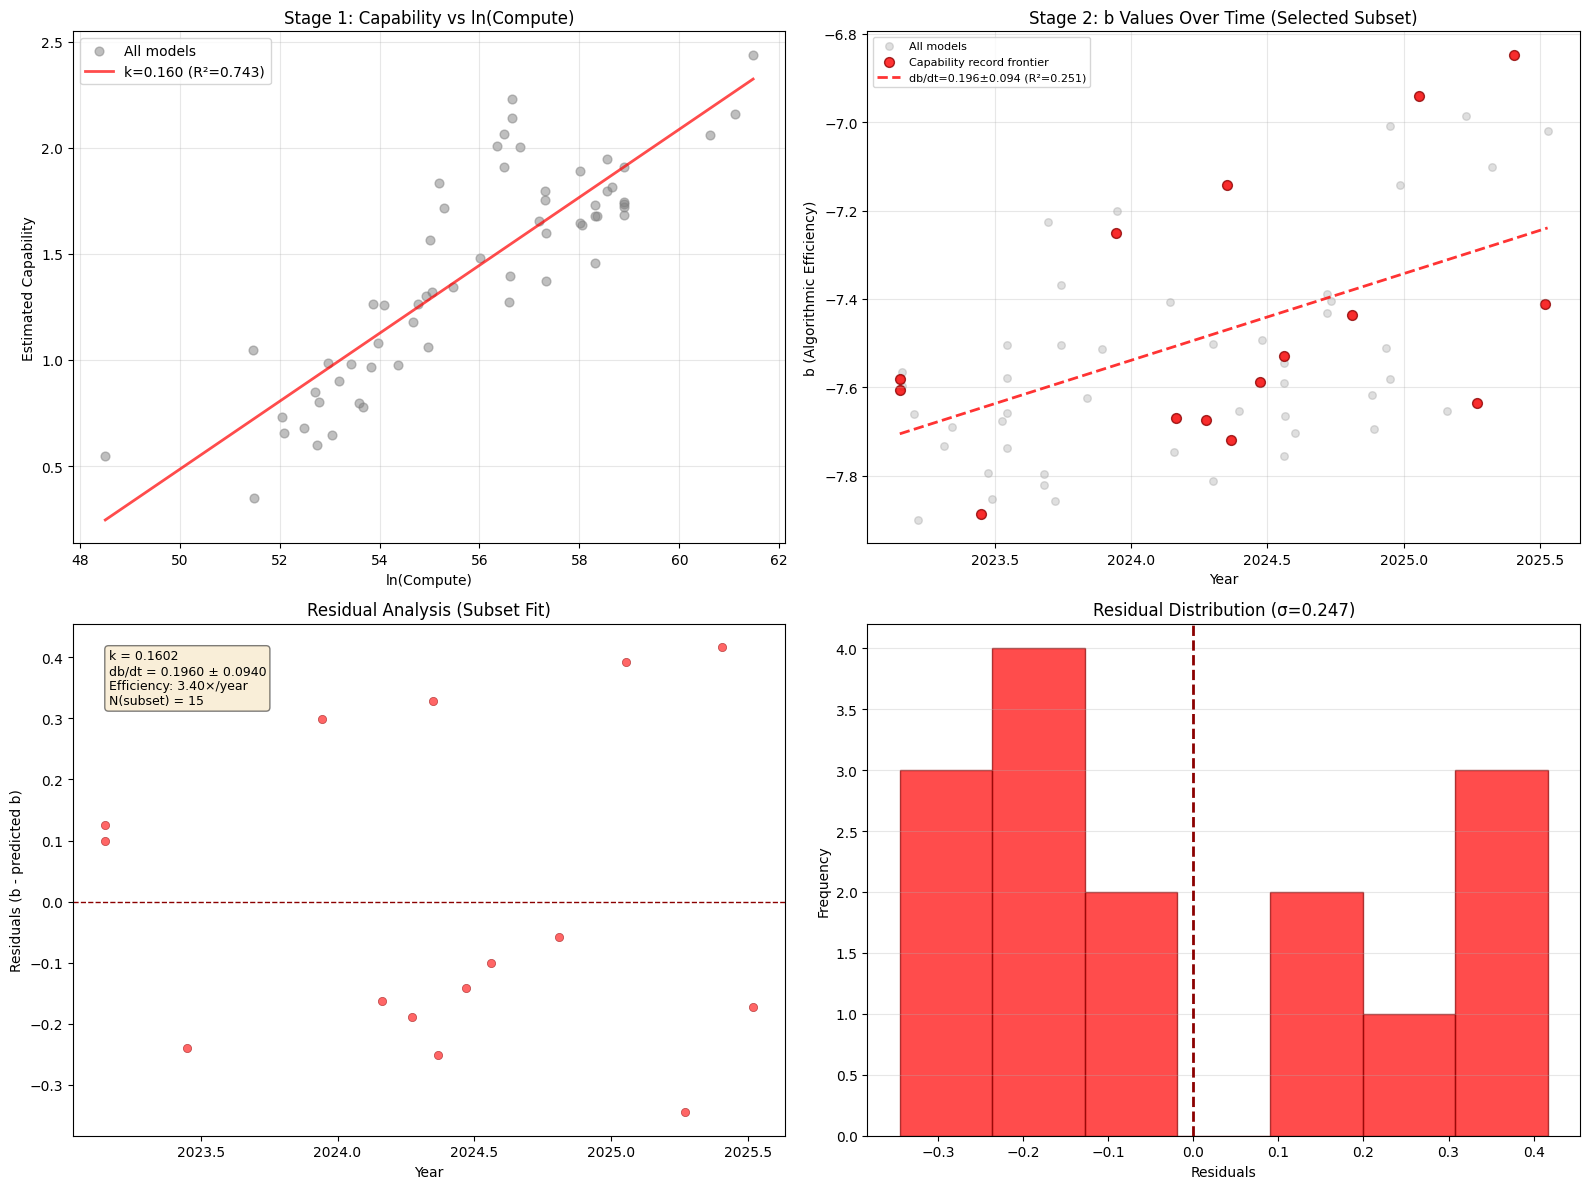

In [18]:
# ============================================================================
# Unified Approach Selector — All Models vs Capability Frontier vs b Frontier
# - Stage 1: Estimate k from all models (pooled)
# - Stage 2: Depending on selection_mode, fit db/dt using:
#   * 'all_models': all models
#   * 'capability_frontier': frontier in estimated_capability (top-N or record)
#   * 'b_frontier': frontier in b (top-N or record)
# - Plots: Stage 1 capability vs ln(compute), Stage 2 b over time, residuals, histogram
# ============================================================================

# Configuration
selection_mode = 'capability_frontier'       # 'all_models' | 'capability_frontier' | 'b_frontier'
frontier_grouping = 'year'          # 'year' | 'month' | 'date' (only used for frontier selection)
frontier_mode = 'record'            # 'record' (running record-high) | 'per_group' (top-N per period)
n_top = 1                           # N for per_group selection

print("=" * 70)
print(f"UNIFIED APPROACH: selection_mode={selection_mode}")
print("=" * 70)

# Prepare data
base_df = df[df['compute'].notna()].copy()
base_df['log_compute'] = np.log(base_df['compute'])
base_df['date_obj'] = pd.to_datetime(base_df['date'])
base_df['date_numeric'] = (
    base_df['date_obj'].dt.year + base_df['date_obj'].dt.dayofyear / 365.25
)

# Stage 1: Estimate k from all models (pooled)
k_all_slope, k_all_intercept, k_all_r, k_all_p, k_all_se = linregress(
    base_df['log_compute'], base_df['estimated_capability']
)
print(f"Stage 1 (all models): k = {k_all_slope:.4f} ± {k_all_se:.4f} (R²={k_all_r**2:.3f})")

# Compute b using all-models k
base_df['b'] = base_df['estimated_capability'] - k_all_slope * base_df['log_compute']

# Frontier selection helpers
if frontier_grouping == 'year':
    base_df['frontier_group'] = base_df['date_obj'].dt.year
elif frontier_grouping == 'month':
    base_df['frontier_group'] = base_df['date_obj'].dt.to_period('M').astype(str)
elif frontier_grouping == 'date':
    base_df['frontier_group'] = base_df['date']
else:
    raise ValueError("frontier_grouping must be 'year', 'month', or 'date'")

if selection_mode == 'all_models':
    subset_df = base_df.copy()
    subset_label = 'All models'
elif selection_mode == 'capability_frontier':
    if frontier_mode == 'per_group':
        subset_df = (
            base_df
            .groupby('frontier_group', group_keys=False)
            .apply(lambda x: x.nlargest(n_top, 'estimated_capability'), include_groups=False)
            .reset_index(drop=True)
        )
        subset_label = f'Top-{n_top} capability per {frontier_grouping}'
    elif frontier_mode == 'record':
        subset_df = base_df.sort_values('date_numeric').copy()
        subset_df['cummax_cap'] = subset_df['estimated_capability'].cummax()
        subset_df = subset_df[subset_df['estimated_capability'] >= subset_df['cummax_cap']].copy()
        subset_label = 'Capability record frontier'
    else:
        raise ValueError("frontier_mode must be 'record' or 'per_group'")
elif selection_mode == 'b_frontier':
    if frontier_mode == 'per_group':
        subset_df = (
            base_df
            .groupby('frontier_group', group_keys=False)
            .apply(lambda x: x.nlargest(n_top, 'b'), include_groups=False)
            .reset_index(drop=True)
        )
        subset_label = f'Top-{n_top} b per {frontier_grouping}'
    elif frontier_mode == 'record':
        subset_df = base_df.sort_values('date_numeric').copy()
        subset_df['cummax_b'] = subset_df['b'].cummax()
        subset_df = subset_df[subset_df['b'] >= subset_df['cummax_b']].copy()
        subset_label = 'b record frontier'
    else:
        raise ValueError("frontier_mode must be 'record' or 'per_group'")
else:
    raise ValueError("selection_mode must be 'all_models', 'capability_frontier', or 'b_frontier'")

print(f"Stage 2 selection: {subset_label}")
print(f"  • Subset size: {len(subset_df)} (of {len(base_df)})")

# Stage 2: Fit db/dt on the selected subset
if len(subset_df) >= 2:
    b_slope_sel, b_int_sel, b_r_sel, b_p_sel, b_se_sel = linregress(
        subset_df['date_numeric'], subset_df['b']
    )
    compute_ratio_per_year_sel = np.exp(-b_slope_sel / k_all_slope)
    efficiency_improvement_per_year_sel = 1 / compute_ratio_per_year_sel
    # 90% CI using t critical with df = n-2
    _n_sel = len(subset_df)
    _df_sel = max(1, _n_sel - 2)
    _t90_sel = t.ppf(0.95, df=_df_sel)
    _eff_lo_sel = np.exp((b_slope_sel - _t90_sel * b_se_sel) / k_all_slope)
    _eff_hi_sel = np.exp((b_slope_sel + _t90_sel * b_se_sel) / k_all_slope)
    print(f"db/dt (subset): {b_slope_sel:.4f} ± {b_se_sel:.4f} per year (R²={b_r_sel**2:.3f}, p={b_p_sel:.2e})")
    print(f"Efficiency improvement: {efficiency_improvement_per_year_sel:.2f}× per year (90% CI: {_eff_lo_sel:.2f}–{_eff_hi_sel:.2f}×)")
else:
    b_slope_sel = b_int_sel = b_r_sel = b_p_sel = b_se_sel = np.nan
    efficiency_improvement_per_year_sel = np.nan
    print("Not enough points to fit a trend (need at least 2)")

# Visualization (2x2)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Stage 1 — Capability vs ln(Compute)
ax1 = axes[0, 0]
ax1.scatter(base_df['log_compute'], base_df['estimated_capability'], alpha=0.5, s=40, c='gray', label='All models')
log_compute_range = np.linspace(base_df['log_compute'].min(), base_df['log_compute'].max(), 100)
capability_line = k_all_slope * log_compute_range + k_all_intercept
ax1.plot(log_compute_range, capability_line, 'r-', linewidth=2, alpha=0.7, label=f'k={k_all_slope:.3f} (R²={k_all_r**2:.3f})')
ax1.set_xlabel('ln(Compute)')
ax1.set_ylabel('Estimated Capability')
ax1.set_title('Stage 1: Capability vs ln(Compute)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Stage 2 — b over time (subset highlighted)
ax2 = axes[0, 1]
ax2.scatter(base_df['date_numeric'], base_df['b'], alpha=0.25, s=30, color='gray', label='All models')
ax2.scatter(subset_df['date_numeric'], subset_df['b'], alpha=0.8, s=50, color='red', edgecolors='darkred', linewidth=1, label=subset_label)
if len(subset_df) >= 2:
    tmin, tmax = base_df['date_numeric'].min(), base_df['date_numeric'].max()
    time_range = np.linspace(tmin, tmax, 100)
    ax2.plot(time_range, b_slope_sel * time_range + b_int_sel, 'r--', linewidth=2, alpha=0.8, label=f'db/dt={b_slope_sel:.3f}±{b_se_sel:.3f} (R²={b_r_sel**2:.3f})')
ax2.set_xlabel('Year')
ax2.set_ylabel('b (Algorithmic Efficiency)')
ax2.set_title('Stage 2: b Values Over Time (Selected Subset)')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

# Plot 3: Residuals (subset fit)
ax3 = axes[1, 0]
if len(subset_df) >= 2:
    pred_b_sel = b_slope_sel * subset_df['date_numeric'] + b_int_sel
    residuals_sel = subset_df['b'] - pred_b_sel
    ax3.scatter(subset_df['date_numeric'], residuals_sel, alpha=0.6, color='red', edgecolors='darkred', linewidth=0.5)
    ax3.axhline(0, color='darkred', linestyle='--', linewidth=1)
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Residuals (b - predicted b)')
    ax3.set_title('Residual Analysis (Subset Fit)')
    textstr = (
        f'k = {k_all_slope:.4f}\n'
        f'db/dt = {b_slope_sel:.4f} ± {b_se_sel:.4f}\n'
        f'Efficiency: {efficiency_improvement_per_year_sel:.2f}×/year\n'
        f'N(subset) = {len(subset_df)}'
    )
    ax3.text(0.05, 0.95, textstr, transform=ax3.transAxes, fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
else:
    ax3.text(0.5, 0.5, 'Insufficient points for residuals', ha='center', va='center')
    ax3.set_axis_off()

# Plot 4: Residuals histogram
ax4 = axes[1, 1]
if len(subset_df) >= 2:
    ax4.hist(residuals_sel, bins=min(20, max(3, len(residuals_sel)//2)), alpha=0.7, color='red', edgecolor='darkred')
    ax4.axvline(0, color='darkred', linestyle='--', linewidth=2)
    ax4.set_xlabel('Residuals')
    ax4.set_ylabel('Frequency')
    ax4.set_title(f'Residual Distribution (σ={np.std(residuals_sel):.3f})')
    ax4.grid(True, alpha=0.3, axis='y')
else:
    ax4.text(0.5, 0.5, 'Insufficient points for residuals', ha='center', va='center')
    ax4.set_axis_off()

plt.tight_layout()
plt.show()


In [19]:
# Interactive Plotly scatter: b over time (unified approach) with hover on model name
import plotly.graph_objects as go

# Ensure required columns exist
assert 'date_obj' in base_df.columns and 'b' in base_df.columns and 'model' in base_df.columns, "base_df missing expected columns"

fig = go.Figure()

# All models trace (light gray)
fig.add_trace(
    go.Scatter(
        x=base_df['date_obj'],
        y=base_df['b'],
        mode='markers',
        name='All models',
        marker=dict(color='rgba(160,160,160,0.35)', size=7),
        text=base_df['model'],
        hovertemplate='Model: %{text}<br>Date: %{x|%Y-%m-%d}<br>b: %{y:.3f}<extra></extra>'
    )
)

# Highlight the selected subset from the unified approach if available
if 'subset_df' in globals() and isinstance(subset_df, pd.DataFrame) and len(subset_df) > 0:
    fig.add_trace(
        go.Scatter(
            x=subset_df['date_obj'],
            y=subset_df['b'],
            mode='markers',
            name=subset_label if 'subset_label' in globals() else 'Selected subset',
            marker=dict(color='rgba(220,20,60,0.9)', size=9, line=dict(width=1, color='darkred')),
            text=subset_df['model'],
            hovertemplate='Model: %{text}<br>Date: %{x|%Y-%m-%d}<br>b: %{y:.3f}<extra></extra>'
        )
    )

fig.update_layout(
    title='Unified Approach: b over time (hover for model name)',
    xaxis_title='Date',
    yaxis_title='b (Algorithmic Efficiency)',
    template='plotly_white',
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1)
)

fig.show()


# Alternative Approach: Compute Reduction at Constant Capabilities


In [20]:
# useful functions
# ------------------------------------------------------------------
# 0.  Data prep  ----------------------------------------------------
df_alt = df_cap.copy()

# make sure the columns we'll need exist and are typed correctly
for col in ["estimated_capability", "date", "compute"]:
    assert col in df_alt.columns, f"missing {col}"
df_alt["date"] = pd.to_datetime(df_alt["date"])
df_alt = df_alt.sort_values("date")

def later_lower_compute(
    row: pd.Series,
    df_level: pd.DataFrame,
    cap_tol_below: Union[int, float] = 0.1,
    cap_tol_above: Union[int, float] = 0.1,
) -> pd.DataFrame:
    """
    Return **all** models that are
      • released after ``row["date"]``,
      • use ≤ the same compute, and
      • have capability within ±``cap_tol`` of the current row.

    Parameters
    ----------
    cap_tol : float
        Half-width of the allowed capability band. Default 0.1 means we keep
        models whose capability lies in
        [row[cap_col] - 0.1, row[cap_col] + 0.1].

    Returns
    -------
    pd.DataFrame
        Qualifying later models, sorted by date (may be empty).
    """
    later_mask   = df_level["date"].gt(row["date"])
    compute_mask = df_level["compute"].le(row["compute"])

    lower_bound  = row["estimated_capability"] - cap_tol_below
    upper_bound  = row["estimated_capability"] + cap_tol_above
    cap_mask     = df_level["estimated_capability"].between(lower_bound, upper_bound, inclusive="both")


    later_matches = df_level.loc[later_mask & compute_mask & cap_mask]
    out = pd.concat([row.to_frame().T, later_matches]).sort_values("date")

    return out


In [21]:
# ------------------------------------------------------------
# Regression + numeric output
# ------------------------------------------------------------
def compute_regression_stats(
    df_slice: pd.DataFrame,
    *,
    date_col: str = "date",
    compute_col: str = "compute",
) -> dict:
    """
    Fit  log10(compute) ~ time  (ordinary least squares).

    Returns
    -------
    dict with keys
        slope_log10              – slope in log10 units per year (should be < 0)
        factor_per_year          – 10**slope (e.g. 0.75 ⇒ 25 % drop/yr)
        pct_reduction_per_year   – (1-factor)*100
        intercept_log10, r_value, p_value, stderr
    """

    df = df_slice.copy()
    # ensure chronological order & datetime dtype
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col)

    # numeric X axis = fractional years since first point
    years = (
        (df[date_col] - df[date_col].iloc[0])
        .dt.total_seconds()
        / (365.25 * 24 * 3600)
    )

    # log-10 transform of compute
    y = np.log10(df[compute_col].astype(float))

    slope, intercept, r, p, se = linregress(years, y)

    factor_per_year        = 10 ** slope          # < 1 if slope negative
    pct_reduction_per_year = (1 - factor_per_year) * 100

    return {
        "slope_log10": slope,
        "intercept_log10": intercept,
        "r_value": r,
        "p_value": p,
        "stderr": se,
        "factor_per_year": 1/factor_per_year,
        "pct_reduction_per_year": pct_reduction_per_year,
    }


# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
def plot_compute_trend(
    df_slice: pd.DataFrame,
    *,
    date_col: str = "date",
    compute_col: str = "compute",
    title: str | None = None,
    ax: plt.Axes | None = None,
):
    """
    Scatter of compute vs date (log-y) with best-fit line overlaid.
    """
    stats = compute_regression_stats(df_slice, date_col=date_col, compute_col=compute_col)

    df = df_slice.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col)

    # X for plotting
    years = (
        (df[date_col] - df[date_col].iloc[0])
        .dt.total_seconds()
        / (365.25 * 24 * 3600)
    )

    # Fitted line in *linear* compute space
    y_fit_log10 = stats["intercept_log10"] + stats["slope_log10"] * years
    y_fit       = 10 ** y_fit_log10

    if ax is None:
        _, ax = plt.subplots()

    ax.scatter(df[date_col], df[compute_col], label="models")
    ax.plot(df[date_col], y_fit, label="OLS fit", linewidth=2)

    ax.set_yscale("log")
    ax.set_xlabel("Date")
    ax.set_ylabel("Training compute")
    ax.set_title(
        title
        or "Compute trend (≈ constant capability)\n"
           f"≈ {stats['pct_reduction_per_year']:.1f}% less compute per year"
    )
    ax.legend()
    plt.tight_layout()


In [22]:
n_min = 10
cap_tol_below = 0.05
cap_tol_above = 99
date_col = "date_obj"
compute_col = "compute"

results = []

for idx, anchor in df_alt.iterrows():
    window = later_lower_compute(anchor, df_alt,
                                  cap_tol_below=cap_tol_below,
                                  cap_tol_above=cap_tol_above)

    if len(window) < n_min:
        # not enough data → skip
        continue

    stats = compute_regression_stats(
        window, date_col=date_col, compute_col=compute_col
    )

    results.append(
        {
            "anchor_idx": idx,
            "anchor_date": anchor[date_col],
            "anchor_model": anchor["model"],
            "n_points": len(window),
            **stats,                     # slope_log10, factor_per_year, …
        }
    )

compute_reduction_df = pd.DataFrame(results)
compute_reduction_df[["anchor_model", "n_points", "factor_per_year", "p_value"]]


,anchor_model,n_points,factor_per_year,p_value
0,gpt-4-0613,18,1.495101,0.389903
1,falcon-180B,13,0.417125,0.045514
2,claude-3-opus-20240229,15,2.217540,0.179960
3,gpt-4-turbo-2024-04-09,16,2.761952,0.144130
4,Meta-Llama-3-70B-Instruct,14,0.765531,0.629960
5,gpt-4o-2024-05-13,20,12.165136,0.000540
6,gemini-1.5-pro-001,13,3.791777,0.029844
7,claude-3-5-sonnet-20240620,12,6.424083,0.033219
8,Llama-3.1-405B-Instruct,16,9.158483,0.011314
9,Llama-3.1-70B-Instruct,11,2.310707,0.206337


In [23]:
print(f"Geometric mean of compute reduction factors: {gmean(compute_reduction_df['factor_per_year']):.2f}×/year")


Geometric mean of compute reduction factors: 3.16×/year


Example model: grok-2-1212
Annual compute reduction ≈ 85.3% (6.783× per year)


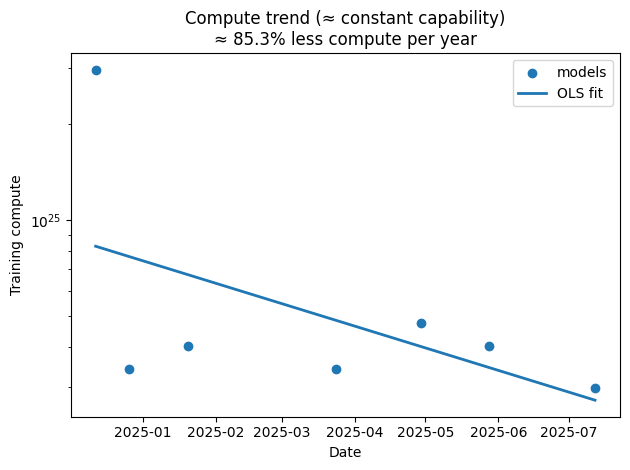

In [25]:
# Example: pick a specific anchor model and visualize its compute reduction trend
example_idx = 32  # You can change this to explore different anchors
window = later_lower_compute(df_alt.loc[example_idx], df_alt,
                             cap_tol_below=cap_tol_below, cap_tol_above=cap_tol_above)
stats   = compute_regression_stats(window)
print(f"Example model: {df_alt.loc[example_idx]['model']}")
print(f"Annual compute reduction ≈ {stats['pct_reduction_per_year']:.1f}% "
      f"({stats['factor_per_year']:.3f}× per year)")

plot_compute_trend(window)


# Capabilities Increase at Fixed Compute


In [26]:
# ---------------------------------------------------------------
# 0.  Data prep  -------------------------------------------------
df_cap_alt = df_cap.copy() 
for col in ["estimated_capability", "date", "compute"]:
    assert col in df_cap_alt.columns, f"missing {col}"
df_cap_alt["date"] = pd.to_datetime(df_cap_alt["date"])
df_cap_alt = df_cap_alt.sort_values("date")


def later_higher_capability(
    df_level: pd.DataFrame,
    *,
    compute_target: Union[int, float],
    date_from: Union[str, pd.Timestamp],
    compute_tol_below: Union[int, float] = 1.0,
    compute_tol_above: Union[int, float] = 1.0,
    # ―― choose *either* a relative improvement … ―――――――――――――――――――――――――――――
    compare_row: Optional[pd.Series] = None,
    # ―― … or an absolute capability floor (ignored if compare_row is given) ――
    cap_floor: Optional[Union[int, float]] = None,
) -> pd.DataFrame:
    """
    Return **all** models that
      • are released after *date_from*,
      • use ≈ the *compute_target* (|Δ| ≤ compute_tol), **and**
      • beat either:
          – compare_row["estimated_capability"] + min_cap_gain,   if *compare_row* is given, or
          – the absolute level *cap_floor*,                       otherwise.

    Parameters
    ----------
    compute_target : float
        The compute budget you want to hold (roughly) constant.
    compute_tol : float, default 0
        Half-width of the allowed compute band.
        e.g. 0.05 means keep models in [target-0.05, target+0.05].
        Use an absolute value; if you prefer relative %, multiply first.
    date_from : str | pd.Timestamp
        Cut-off date – only later releases are considered.
    compare_row : pd.Series, optional
        If provided we measure "higher capability" relative to this row.
        If omitted we fall back to *cap_floor* (must then be supplied).
    min_cap_gain : float, default 0.1
        The minimum improvement over *compare_row* we insist on.
    cap_floor : float, optional
        Absolute capability threshold if *compare_row* is None.

    Returns
    -------
    pd.DataFrame
        Qualifying later models, sorted by date (may be empty).
    """
    date_from = pd.to_datetime(date_from)

    # later in time ------------------------------------------------
    later_mask = df_level["date"].gt(date_from)

    # roughly equal compute ---------------------------------------
    lower_compute = compute_target / compute_tol_below
    upper_compute = compute_target * compute_tol_above
    compute_mask = df_level["compute"].between(lower_compute, upper_compute, inclusive="both")

    # capability strictly higher ----------------------------------
    if compare_row is not None:
        cap_threshold = compare_row["estimated_capability"]
    elif cap_floor is not None:
        cap_threshold = cap_floor
    else:
        raise ValueError("Supply either compare_row or cap_floor")

    cap_mask = df_level["estimated_capability"].gt(cap_threshold)

    # ----------------------------------------------------------------
    later_better = df_level.loc[later_mask & compute_mask & cap_mask]
    return later_better.sort_values("date")


In [27]:
# ------------------------------------------------------------
# 1 A.  Regression stats
# ------------------------------------------------------------
def capability_regression_stats(
    df_slice: pd.DataFrame,
    *,
    date_col: str = "date",
    cap_col: str = "estimated_capability",
) -> dict:
    """
    Fit  capability ~ time  (ordinary least squares).

    Returns
    -------
    dict with keys
        slope_per_year            – capability units gained per year
        intercept, r_value, p_value, stderr
    """
    df = df_slice.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col)

    # numeric X axis = fractional years since first point
    years = (
        (df[date_col] - df[date_col].iloc[0])
        .dt.total_seconds()
        / (365.25 * 24 * 3600)
    )

    y = df[cap_col].astype(float)

    slope, intercept, r, p, se = linregress(years, y)

    return {
        "slope_per_year": slope,
        "intercept": intercept,
        "r_value": r,
        "p_value": p,
        "stderr": se,
    }

# ------------------------------------------------------------
# 1 B.  Plot capability trend
# ------------------------------------------------------------
def plot_capability_trend(
    df_slice: pd.DataFrame,
    *,
    date_col: str = "date",
    cap_col: str = "estimated_capability",
    title: str | None = None,
    ax: plt.Axes | None = None,
):
    """
    Scatter of capability vs date (linear y) with best-fit line.
    """
    stats = capability_regression_stats(df_slice, date_col=date_col, cap_col=cap_col)

    df = df_slice.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col)

    years = (
        (df[date_col] - df[date_col].iloc[0])
        .dt.total_seconds()
        / (365.25 * 24 * 3600)
    )
    y_fit = stats["intercept"] + stats["slope_per_year"] * years

    if ax is None:
        _, ax = plt.subplots()

    ax.scatter(df[date_col], df[cap_col], label="models")
    ax.plot(df[date_col], y_fit, label="OLS fit", linewidth=2)

    ax.set_xlabel("Date")
    ax.set_ylabel("Estimated capability")
    ax.set_title(
        title
        or "Capability trend (≈ constant compute)\n"
           f"≈ {stats['slope_per_year']:.3f} capability units gained per year"
    )
    ax.legend()
    plt.tight_layout()


In [28]:
# ------------------------------------------------------------
# 2.  Iterate over anchors, build summary table
# ------------------------------------------------------------
n_min_cap = 5                       # require ≥ this many points in a window
compute_tol_below_cap = 1e5
compute_tol_above_cap = 1.05

results_cap = []

for idx, anchor in df_cap_alt.iterrows():
    window = later_higher_capability(
        df_cap_alt,
        compute_target=anchor["compute"],
        date_from=anchor["date"],
        compare_row=anchor,
        compute_tol_below=compute_tol_below_cap,
        compute_tol_above=compute_tol_above_cap,
    )

    if len(window) < n_min_cap:
        continue        # not enough data → skip

    stats = capability_regression_stats(window)

    results_cap.append(
        {
            "anchor_idx": idx,
            "anchor_model": anchor["model"],
            "anchor_date": anchor["date"],
            "n_points": len(window),
            **stats,                         # slope_per_year, r_value, …
        }
    )

summary_cap_df = pd.DataFrame(results_cap)
summary_cap_df


,anchor_idx,anchor_model,anchor_date,n_points,slope_per_year,intercept,r_value,p_value,stderr
0,51,gpt-4-0613,2023-06-13,20,0.393818,1.479381,0.824876,0.000008,0.063615
1,77,mpt-30b,2023-06-22,5,0.297986,0.889798,0.556291,0.330158,0.256997
2,54,claude-2.0,2023-07-11,9,0.422234,1.488003,0.856257,0.003212,0.096275
3,60,falcon-180B,2023-09-06,9,0.442637,1.356055,0.785919,0.012037,0.131625
4,46,claude-3-opus-20240229,2024-02-29,13,0.402022,1.655423,0.789804,0.001319,0.094135
5,43,gpt-4-turbo-2024-04-09,2024-04-09,13,0.410001,1.655479,0.815180,0.000685,0.087835
6,55,Meta-Llama-3-70B-Instruct,2024-04-18,13,0.501223,1.564102,0.824907,0.000519,0.103558
7,39,gpt-4o-2024-05-13,2024-05-13,17,0.346624,1.741270,0.702401,0.001667,0.090693
8,45,gemini-1.5-pro-001,2024-05-24,11,0.430081,1.791874,0.707078,0.014962,0.143372
9,34,claude-3-5-sonnet-20240620,2024-06-20,10,0.326032,1.867299,0.690332,0.027125,0.120807


In [29]:
s = summary_cap_df["slope_per_year"].dropna().to_numpy()
positive = s[s > 0]
geo_mean = gmean(positive) if positive.size else np.nan
print(f"Geometric mean of capability increase (positive slopes only): {geo_mean:.3f} capability units/year")
print(f"Arithmetic mean of capability increase (all slopes): {np.mean(summary_cap_df['slope_per_year']):.3f} capability units/year")


Geometric mean of capability increase (positive slopes only): 0.340 capability units/year
Arithmetic mean of capability increase (all slopes): 0.335 capability units/year


Example model: grok-2-1212
Number of qualifying later models: 6


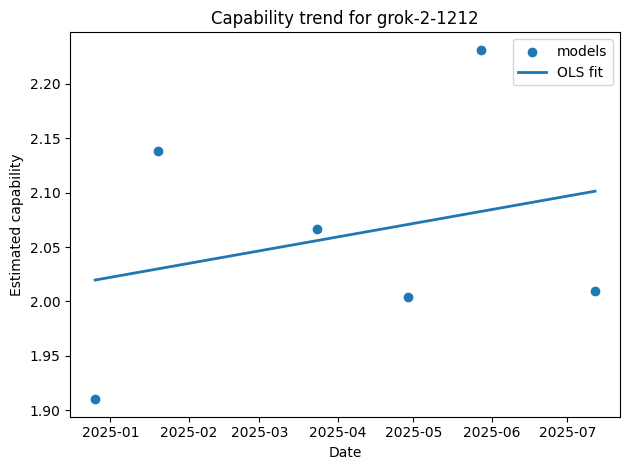

In [31]:
# Example: visualize capability increase for a specific anchor model
baseline = df_cap_alt.loc[32]
window = later_higher_capability(
    df_cap_alt,
    compute_target=baseline["compute"],
    date_from=baseline["date"],
    compare_row=baseline,
    compute_tol_below=1000,
    compute_tol_above=1.05,
)

print(f"Example model: {baseline['model']}")
print(f"Number of qualifying later models: {len(window)}")

if len(window) > 0:
    plot_capability_trend(window, title=f"Capability trend for {baseline['model']}")


# Frontier Models Analysis


In [32]:
# Identify frontier models - those that set a new capability record at their release
df_frontier = df_cap_alt.sort_values('date').copy()
df_frontier['cummax_capability'] = df_frontier['estimated_capability'].cummax()
df_frontier['is_frontier'] = df_frontier['estimated_capability'] >= df_frontier['cummax_capability']

# Get only the frontier models
frontier_models = df_frontier[df_frontier['is_frontier']].copy()

print(f"Total models with compute data: {len(df_cap_alt)}")
print(f"Frontier models (set new capability record): {len(frontier_models)}")
print(f"\nFrontier models:")
print(frontier_models[['date', 'model', 'estimated_capability', 'compute']].to_string(index=False))


Total models with compute data: 87
Frontier models (set new capability record): 16

Frontier models:
      date                        model  estimated_capability      compute
2023-02-24                    LLaMA-65B              1.178812 5.500000e+23
2023-06-13                   gpt-4-0613              1.456790 2.100000e+25
2023-12-11            Mixtral-8x7B-v0.1              1.563512 7.740000e+23
2024-02-29       claude-3-opus-20240229              1.634670 1.640001e+25
2024-04-09       gpt-4-turbo-2024-04-09              1.676166 2.200000e+25
2024-05-07                  DeepSeek-V2              1.716417 1.020000e+24
2024-05-13            gpt-4o-2024-05-13              1.720033 3.810001e+25
2024-06-20   claude-3-5-sonnet-20240620              1.795381 2.700000e+25
2024-07-23               Llama-3.1-405B              1.908871 3.800000e+25
2024-09-12        o1-preview-2024-09-12              2.034879          NaN
2024-12-17         o1-2024-12-17_medium              2.265395          NaN

## Capability Increase at Fixed Compute - Frontier Models Only


In [34]:
# Now run the capability increase analysis but only for frontier models as anchors
n_min_frontier = 3  # Minimum number of qualifying later models
compute_tol_below_frontier = 1e5  # More relaxed tolerance for lower compute
compute_tol_above_frontier = 1.05  # Strict tolerance for upper compute (≤5% more)

results_frontier = []

for idx, anchor in frontier_models.iterrows():
    window = later_higher_capability(
        df_cap_alt,  # Search in all models
        compute_target=anchor["compute"],
        date_from=anchor["date"],
        compare_row=anchor,
        compute_tol_below=compute_tol_below_frontier,
        compute_tol_above=compute_tol_above_frontier,
    )

    if len(window) < n_min_frontier:
        continue  # Not enough data → skip

    stats = capability_regression_stats(window)

    results_frontier.append(
        {
            "anchor_idx": idx,
            "anchor_model": anchor["model"],
            "anchor_date": anchor["date"],
            "anchor_capability": anchor["estimated_capability"],
            "anchor_compute": anchor["compute"],
            "n_points": len(window),
            **stats,  # slope_per_year, r_value, …
        }
    )

summary_frontier_df = pd.DataFrame(results_frontier)

print(f"Frontier models analyzed: {len(summary_frontier_df)} (of {len(frontier_models)} total frontier models)")
print(f"\nCapability increase rates for frontier models:")
summary_frontier_df[["anchor_model", "anchor_date", "n_points", "slope_per_year", "r_value", "p_value"]]


Frontier models analyzed: 6 (of 16 total frontier models)

Capability increase rates for frontier models:


,anchor_model,anchor_date,n_points,slope_per_year,r_value,p_value
0,gpt-4-0613,2023-06-13,20,0.393818,0.824876,0.000008
1,claude-3-opus-20240229,2024-02-29,13,0.402022,0.789804,0.001319
2,gpt-4-turbo-2024-04-09,2024-04-09,13,0.410001,0.815180,0.000685
3,gpt-4o-2024-05-13,2024-05-13,17,0.346624,0.702401,0.001667
4,claude-3-5-sonnet-20240620,2024-06-20,10,0.326032,0.690332,0.027125
5,Llama-3.1-405B,2024-07-23,7,0.196916,0.447477,0.314052


In [35]:
# Calculate summary statistics for frontier models
if len(summary_frontier_df) > 0:
    s_frontier = summary_frontier_df["slope_per_year"].dropna().to_numpy()
    positive_frontier = s_frontier[s_frontier > 0]
    
    if positive_frontier.size > 0:
        geo_mean_frontier = gmean(positive_frontier)
        print(f"Geometric mean of capability increase (frontier models, positive slopes only): {geo_mean_frontier:.3f} capability units/year")
    else:
        print("No positive slopes found among frontier models")
    
    mean_frontier = np.mean(summary_frontier_df['slope_per_year'])
    median_frontier = np.median(summary_frontier_df['slope_per_year'])
    
    print(f"Arithmetic mean of capability increase (frontier models, all slopes): {mean_frontier:.3f} capability units/year")
    print(f"Median capability increase (frontier models): {median_frontier:.3f} capability units/year")
    
    # Compare with all models
    if len(summary_cap_df) > 0:
        mean_all = np.mean(summary_cap_df['slope_per_year'])
        print(f"\nComparison:")
        print(f"  Frontier models: {mean_frontier:.3f} capability units/year")
        print(f"  All models: {mean_all:.3f} capability units/year")
        print(f"  Ratio: {mean_frontier/mean_all:.2f}×")
else:
    print("No frontier models met the criteria for capability increase analysis")


Geometric mean of capability increase (frontier models, positive slopes only): 0.336 capability units/year
Arithmetic mean of capability increase (frontier models, all slopes): 0.346 capability units/year
Median capability increase (frontier models): 0.370 capability units/year

Comparison:
  Frontier models: 0.346 capability units/year
  All models: 0.335 capability units/year
  Ratio: 1.03×


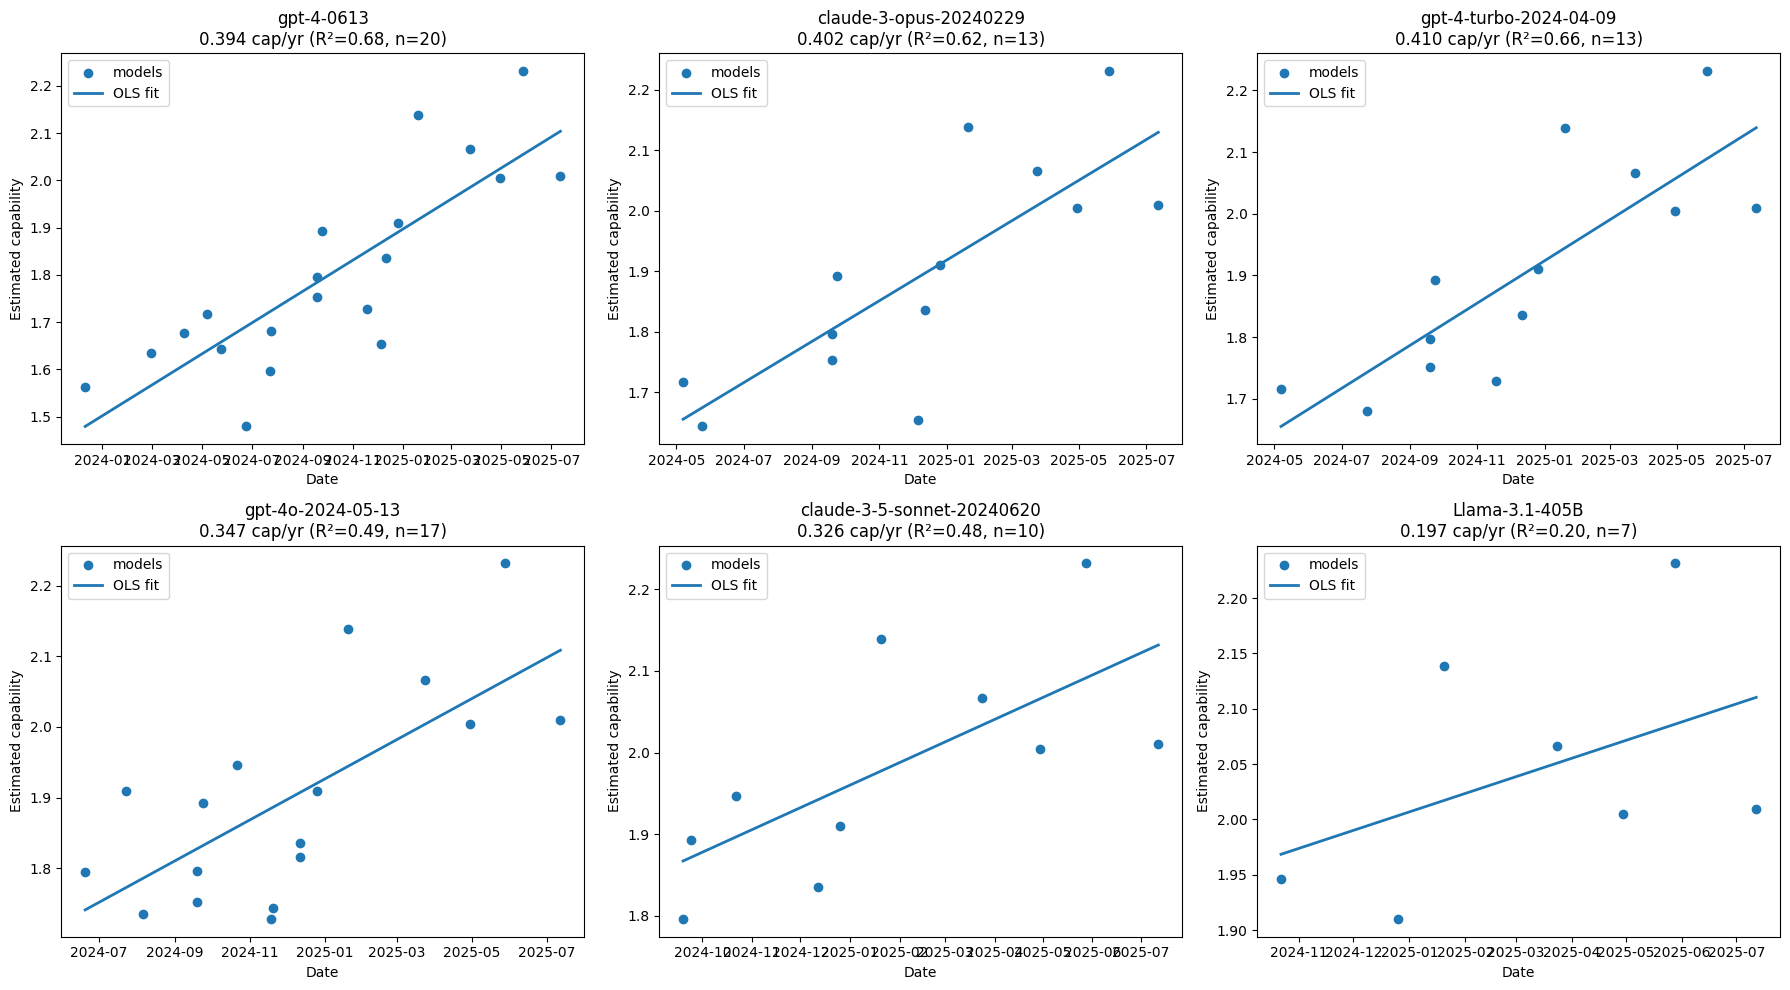

In [36]:
# Visualize capability increase for each frontier model that has sufficient data
if len(summary_frontier_df) > 0:
    n_plots = len(summary_frontier_df)
    n_cols = min(3, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    if n_plots == 1:
        axes = np.array([axes])
    axes = axes.flatten() if n_plots > 1 else axes
    
    for i, (idx, row) in enumerate(summary_frontier_df.iterrows()):
        anchor_idx = row['anchor_idx']
        anchor = df_cap_alt.loc[anchor_idx]
        
        window = later_higher_capability(
            df_cap_alt,
            compute_target=anchor["compute"],
            date_from=anchor["date"],
            compare_row=anchor,
            compute_tol_below=compute_tol_below_frontier,
            compute_tol_above=compute_tol_above_frontier,
        )
        
        if len(window) >= n_min_frontier:
            plot_capability_trend(
                window, 
                title=f"{anchor['model']}\n{row['slope_per_year']:.3f} cap/yr (R²={row['r_value']**2:.2f}, n={row['n_points']})",
                ax=axes[i]
            )
    
    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
else:
    print("No plots to show - insufficient data for frontier models")
